### Mapping of A3, A4, A8, and A9 fetal human colon 10X Genomics Visium samples and `cell2location`

- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 6th August 2024
- **Last modified date:** 6th August 2024

##### Import packages

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams

import torch

import os

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
absl                        NA
aiohttp                     3.9.1
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.3
cell2location               0.1.3
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
comm                        0.2.1
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2

In [3]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

# Train the reference

### Read in data

In [28]:
adata_ref = sc.read_h5ad('/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/reference_datasets/Fetal_colon_reference.h5ad')

In [9]:
reference_results = '/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/fetal_colon_reference_signatures'

+ Permissive genes selection

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


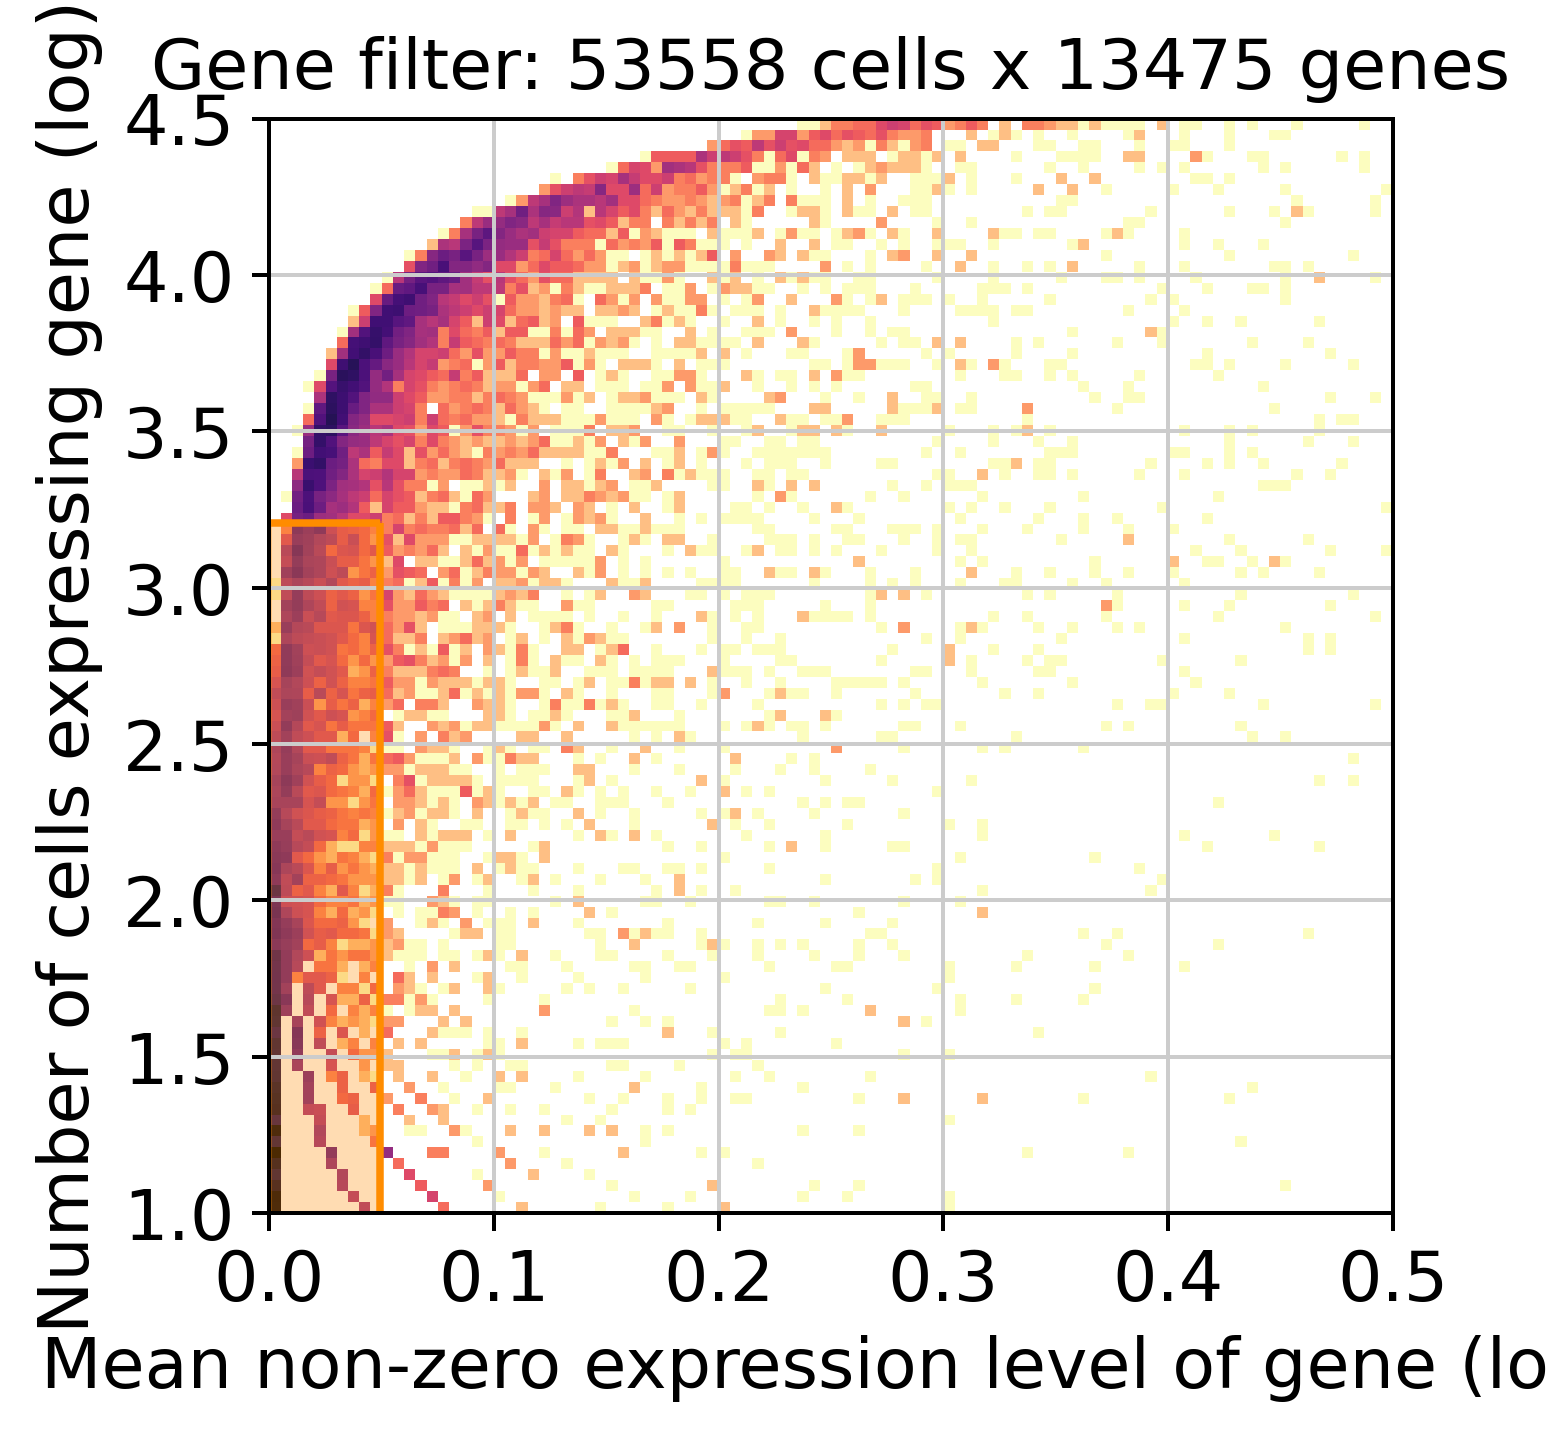

In [29]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signatures (NB regression)

In [30]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample_ID',
                        # cell type, covariate used for constructing signatures
                        labels_key='seed_labels',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Study_name', 'Library_Preparation_Protocol']
                       )

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 29 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [31]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': 'seed_labels',
│   'categorical_covariate_keys': ['Study_name', 'Library_Preparation_Protocol'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  17   │
│         n_cells          │ 53558 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  95   │
│          n_vars          │ 13475 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                             batch State Registry                              
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃          Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     BRC2026_8.4Wk_FLI_SC     │          0          │
│                        │     BRC2029_6.1Wk_FLI_SC     │          1          │
│                        │ BRC2043_10.2Wk_FLI_SC-EPCAMP │          2          │
│                        │ BRC2046_6.7Wk_FLI_SC-EPCAMP  │          3          │
│                        │ BRC2049_6.9Wk_FLI_SC-EPCAMP  │          4          │
│                        │ BRC2119_7.9Wk_FLI_SC-EPCAMP  │          5          │
│                        │ BRC2121_9.2Wk_FLI_SC-EPCAMP  │          6          │
│                        │ BRC2133_9.9Wk_FLI_SC-EPCAMN  │          7          │
│                        │ BRC2133_9.9Wk_FLI_SC-EPCAMP  │          8          │
│                        │  BRC2134_10Wk_FLI_SC-EPCAMN  │          9          │
│                        │  BRC2134_10Wk_FLI_SC-EPCAMP  │         10          │
│                        │       C74-FLI-0-SC-1 G       │         11          │
│                        │        F66-FLI-0-SC-1        │         12          │
│                        │        F67-FLI-0-SC-1        │         13          │
│                        │        F72-FLI-0-SC-1        │         14          │
│                        │        F73-FLI-0-SC-1        │         15          │
│                        │        F78-FLI-0-SC-1        │         16          │
└────────────────────────┴──────────────────────────────┴─────────────────────┘

                              labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │          Activated T          │          0          │
│                          │       BEST4+ epithelial       │          1          │
│                          │        Branch A1 (iMN)        │          2          │
│                          │      Branch A2 (IPAN/IN)      │          3          │
│                          │      Branch A3 (IPAN/IN)      │          4          │
│                          │        Branch A4 (IN)         │          5          │
│                          │        Branch B1 (eMN)        │          6          │
│                          │        Branch B2 (eMN)        │          7          │
│                          │       Branch B3 (IPAN)        │          8          │
│                          │        CLC+ Mast cell         │          9          │
│                          │         CLDN10+ cells         │         10          │
│                          │              CLP              │         11          │
│                          │          Colonocyte           │         12          │
│                          │  Contractile pericyte (PLN+)  │         13          │
│                          │        D cells (SST+)         │         14          │
│                          │     Differentiating glia      │         15          │
│                          │       Distal progenitor       │         16          │
│                          │        EC cells (NPW+)        │         17          │
│                          │       EC cells (TAC1+)        │         18          │
│                          │             EECs              │         19          │
│                          │     ENCC/glia Progenitor      │         20          │
│                          │          Enterocyte           │         21          │
│                          │       Fetal arterial EC       │         22          │
│                          │        Fetal venous EC        │         23          │
│                          │             Germ              │         24          │
│                          │         Glia 1 (DHH+)         │         25          │
│                          │         Glia 2 (ELN+)         │         26          │
│                          │        Glia 3 (BCAN+)         │         27          │
│                          │          Goblet cell          │         28          │
│                          │        I cells (CCK+)         │         29          │
│                          │              ICC              │         30          │
│                          │             ILC2              │         31          │
│                          │             ILCP              │         32          │
│                          │          Immature B           │         33          │
│                          │       Immature pericyte       │         34          │
│                          │        L cells (PYY+)         │         35          │
│                          │         LEC1 (ACKR4+)         │         36          │
│                          │        LEC2 (MADCAM1+)        │         37          │
│                          │         LEC4 (STAB2+)         │         38          │
│                          │      LTi-like NCR+ ILC3       │         39          │
│                          │      LTi-like NCR- ILC3       │         40          │
│                          │       LYVE1+ Macrophage       │         41          │
│                          │          Lymphoid DC          │         42          │
│                          │     M/X cells (MLN/GHRL+)     │         43          │
│               

                        extra_categorical_covs State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃              Source Location              ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Library_Preparation_Protocol'] │    10x 3' v1     │          0          │
│                                           │    10x 5' v1     │          1          │
│                                           │                  │                     │
│          adata.obs['Study_name']          │ Elmentaite, 2021 │          0          │
│                                           │                  │                     │
└───────────────────────────────────────────┴──────────────────┴─────────────────────┘

+ Train the model

In [32]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Then run your cell2location code
mod.train(
    max_epochs=150,
    use_gpu=True,
    accelerator="gpu",
    enable_progress_bar=True,
)

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|█████████████████████| 150/150 [03:29<00:00,  1.40s/it, v_num=1, elbo_train=3.36e+8]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|█████████████████████| 150/150 [03:29<00:00,  1.40s/it, v_num=1, elbo_train=3.36e+8]


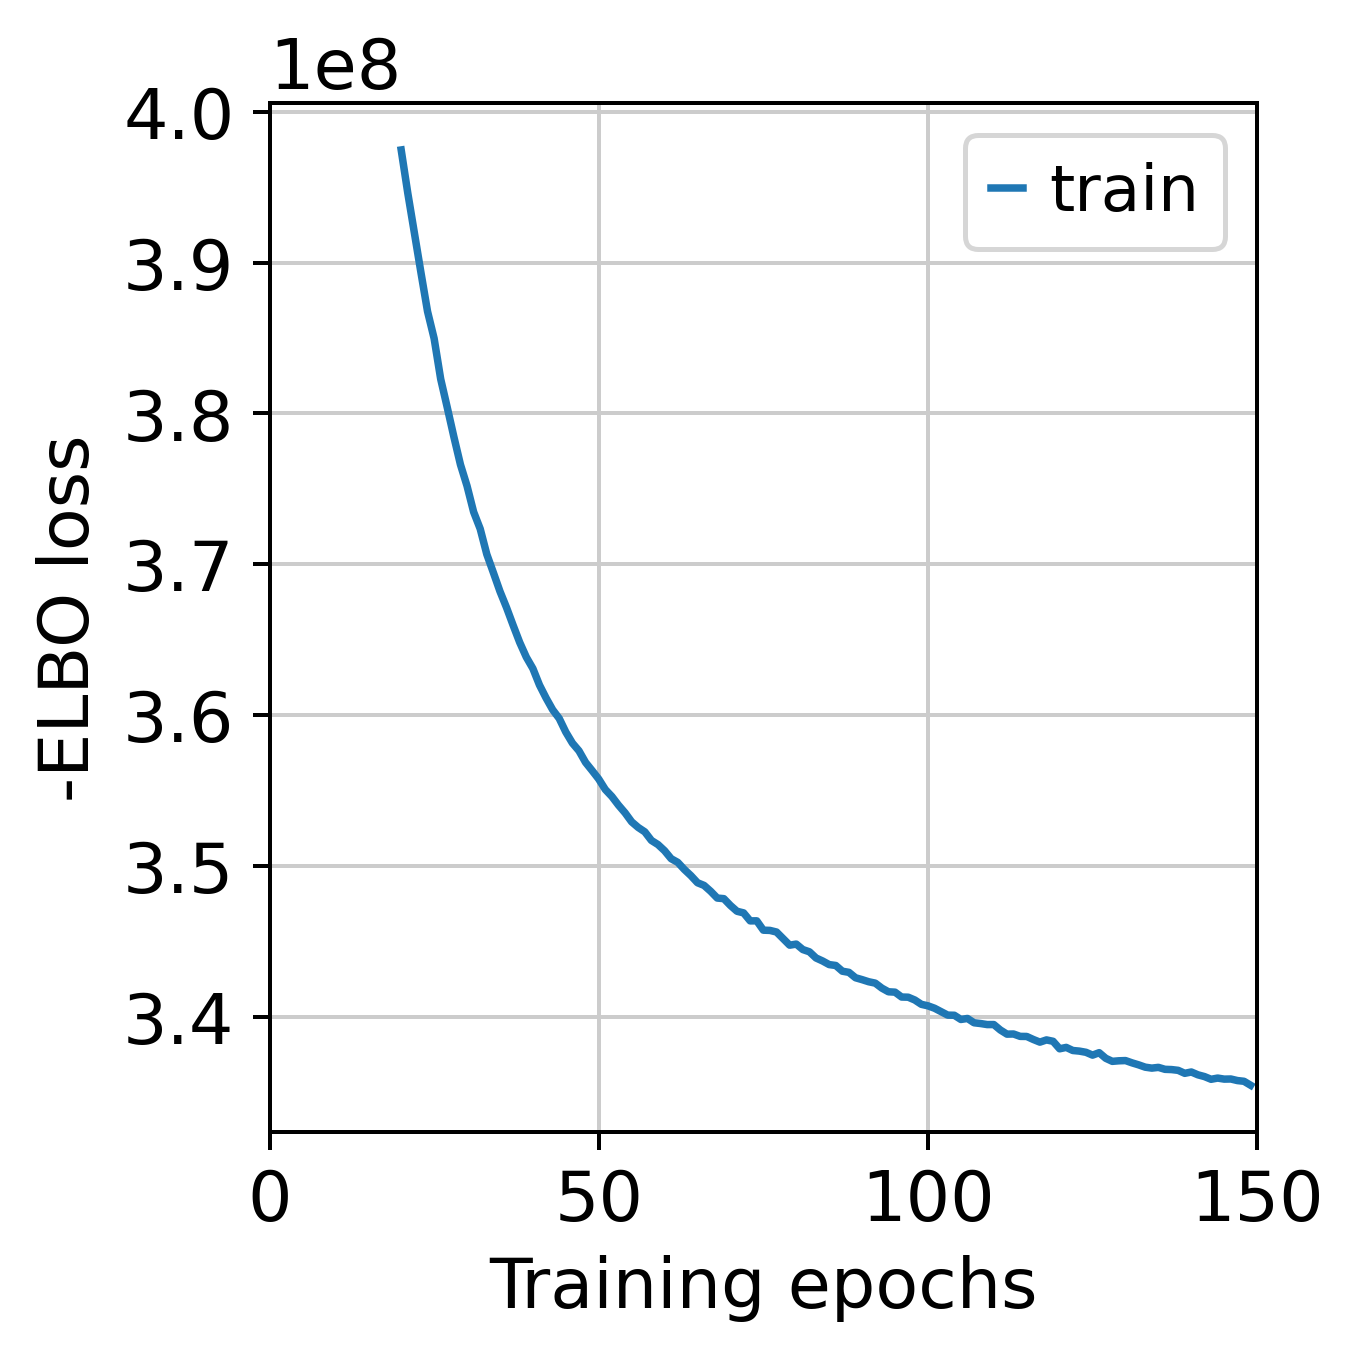

In [33]:
mod.plot_history(20)

In [34]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:06<00:00, 149.40it/s]


In [35]:
# Save model
mod.save(f"{reference_results}/", overwrite=True)

# Save anndata object with results
adata_file = f"{reference_results}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/fetal_colon_reference_signatures/sc.h5ad'

+ Examine QC plots

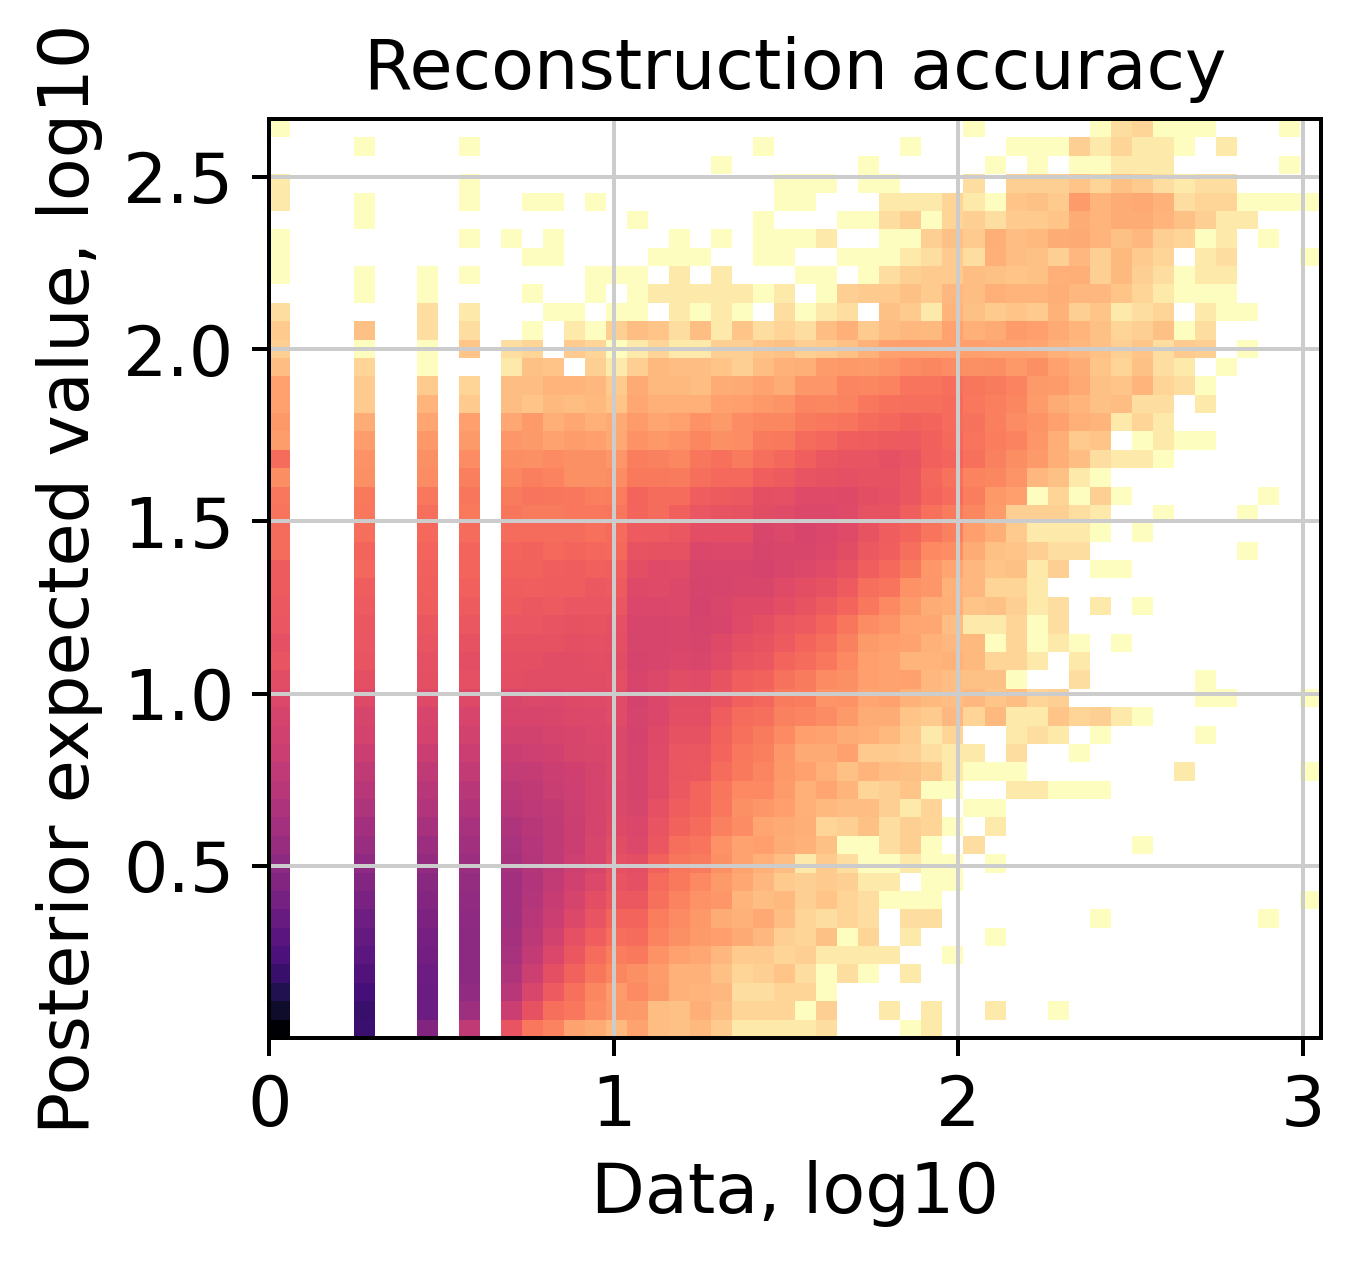

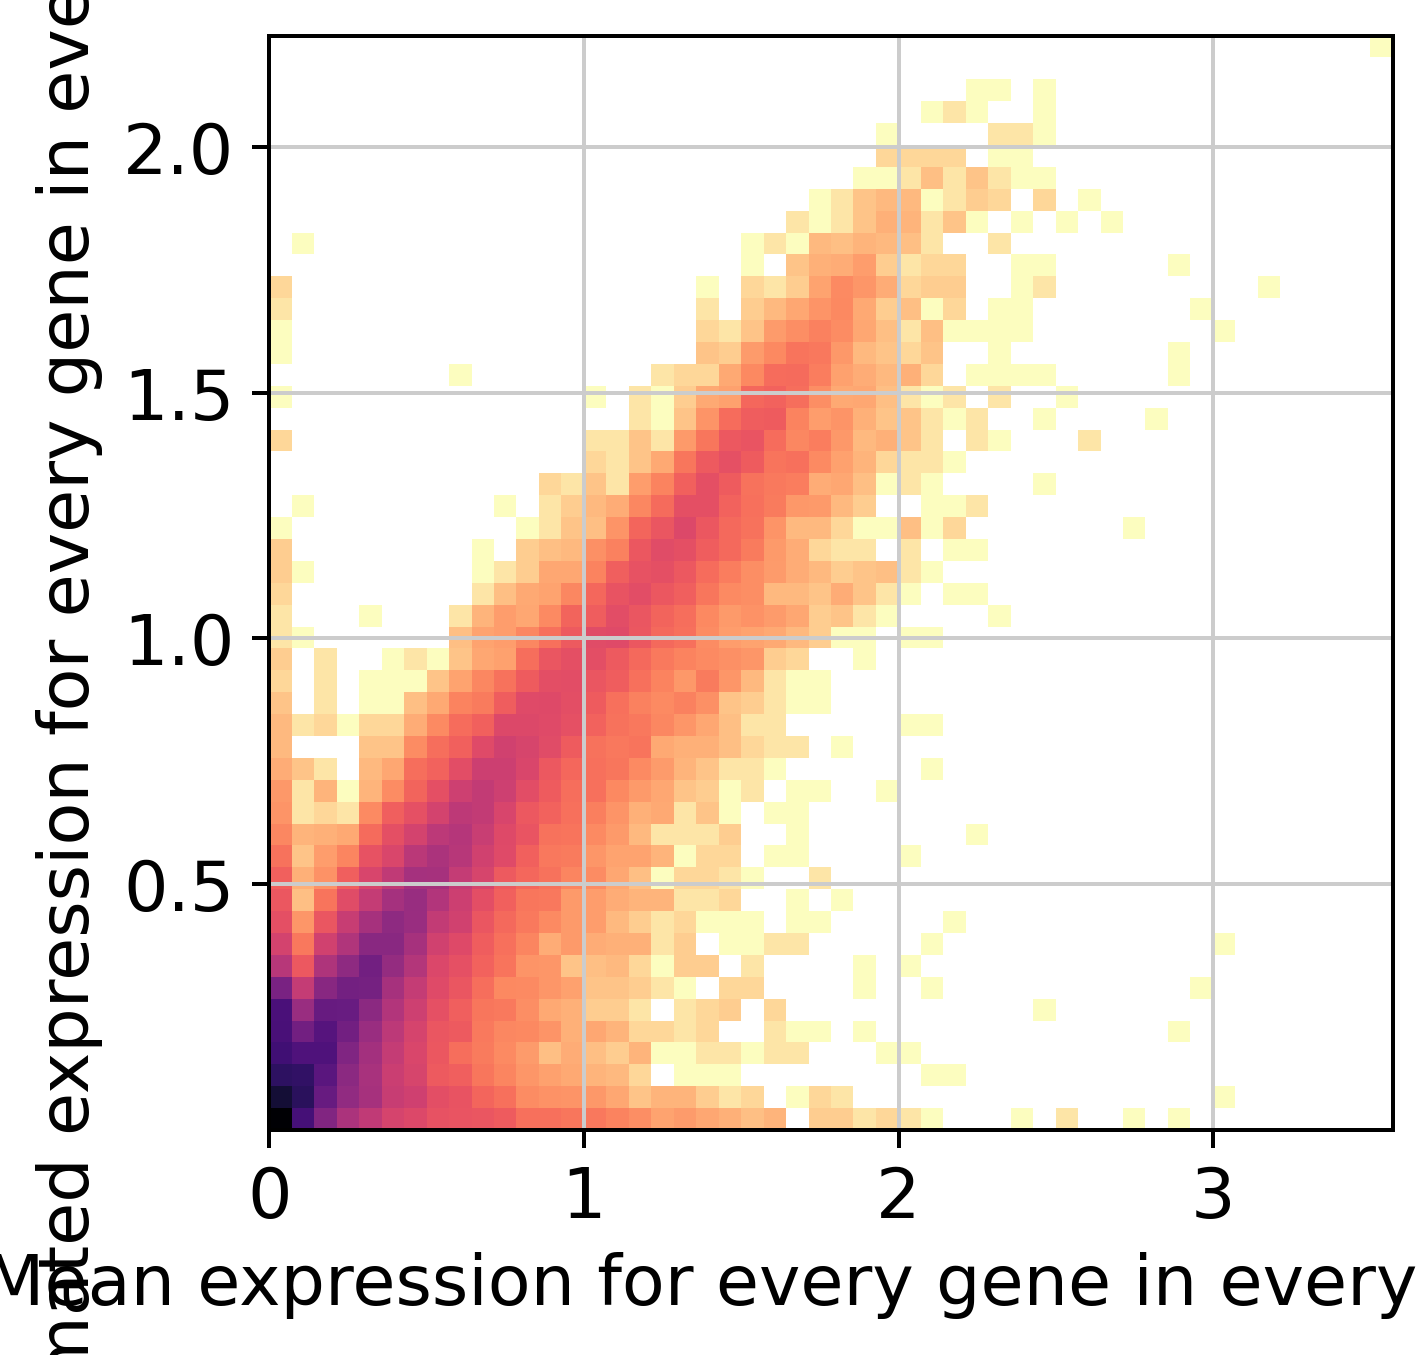

In [36]:
mod.plot_QC()

In [37]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Activated T,BEST4+ epithelial,Branch A1 (iMN),Branch A2 (IPAN/IN),Branch A3 (IPAN/IN)
gene_ids,,,,,
A1BG,0.236314,0.011777,0.164333,0.145132,0.163083
A1CF,0.023012,0.486183,0.001921,0.004112,0.009547
A2M,0.098528,0.020799,0.007336,0.015445,0.068924
A4GALT,0.024760,0.011315,0.003136,0.015210,0.027564
AAAS,0.060599,0.091847,0.138162,0.161428,0.296883


## Cell2location: spatial mapping

In [6]:
visium_results = '/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/'
visium_slides = '/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/slides_anndata_objects/'

### Slide A3 (Fetal donor B, 12PCW, whole colon section slide)

In [39]:
sample = 'A3'

visium = sc.read_h5ad(f'{visium_slides}/{sample}_raw.h5ad')

In [40]:
visium.var_names_make_unique()

In [41]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium.var_names, inf_aver.index)
visium = visium[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium, batch_key="Sample_ID")

In [42]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2782  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11811 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A3     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:19<00:00, 17.41it/s, v_num=1, elbo_train=1.44e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:19<00:00, 18.22it/s, v_num=1, elbo_train=1.44e+7]


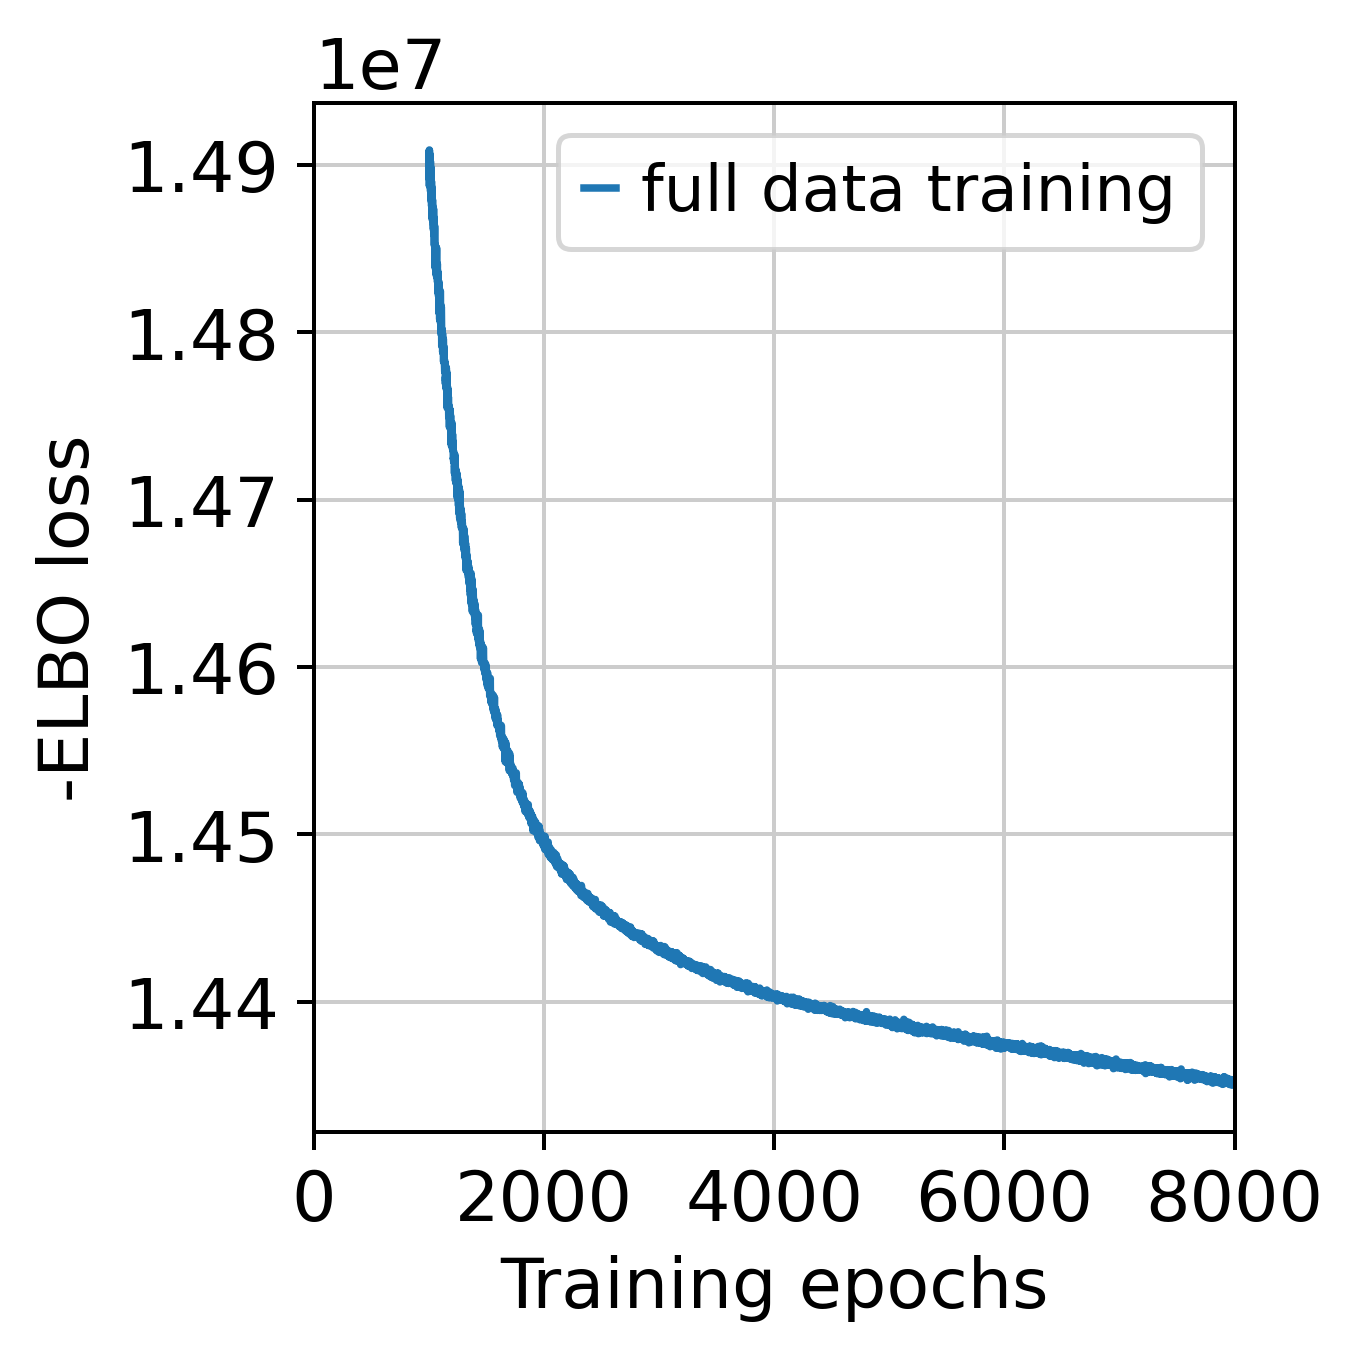

In [43]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [44]:
visium = mod.export_posterior(
    visium, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:09<00:00, 103.47it/s]


In [45]:
mod.save(f"{visium_results}/{sample}/cell2location_map", overwrite=True)

adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A3/cell2location_map/sp.h5ad'

+ Assessing mapping quality

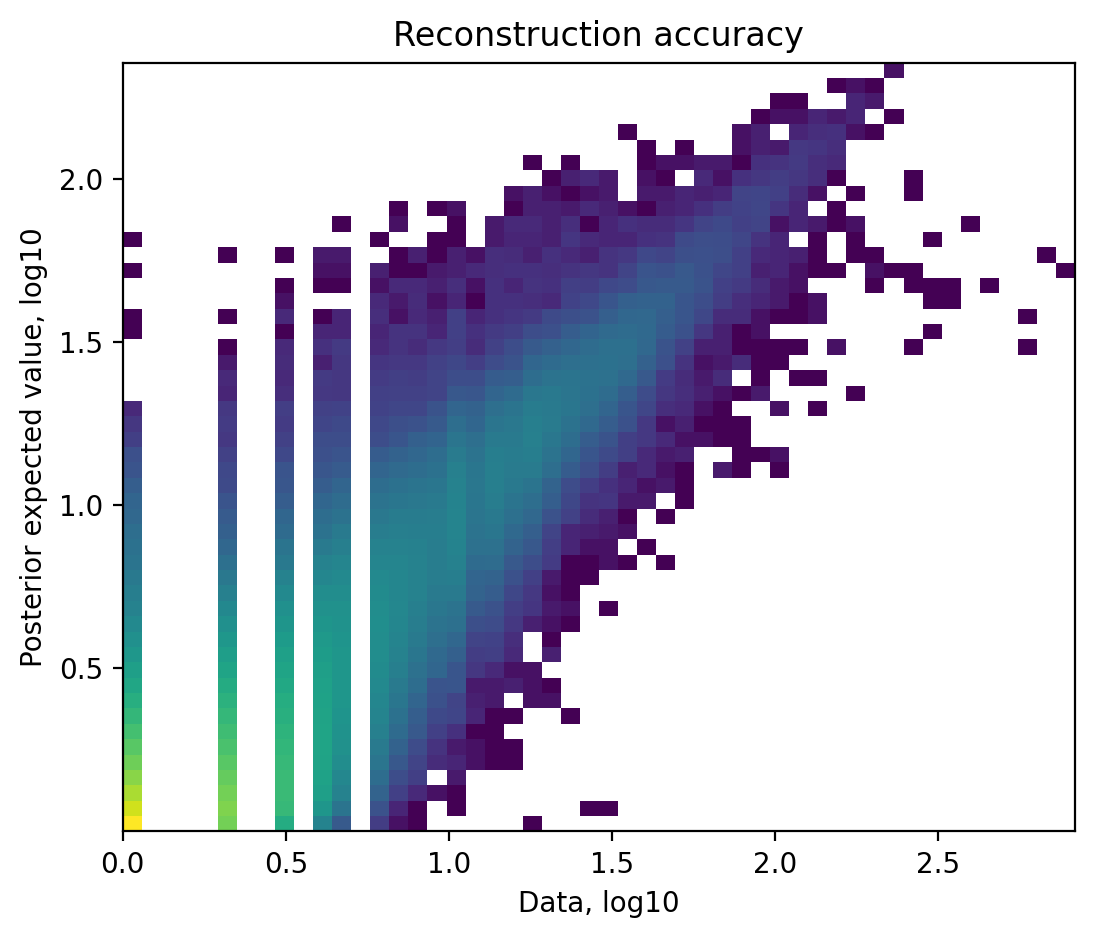

In [72]:
output_filename = f"{visium_results}/{sample}/{sample}_reconstruction_accuracy.png"
mod.plot_QC()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Visualising cell abundance in spatial coordinates

In [47]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']

/tmp/ipykernel_1801561/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_1801561/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']


In [48]:
visium.obs['sample'] = 'tissue42'

/tmp/ipykernel_1801561/2867631362.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs['sample'] = 'tissue42'


In [49]:
visium

AnnData object with n_obs × n_vars = 2782 × 11811
    obs: 'SRA_sample', 'Sample_ID', 'Sequincing_protocol', 'Library_preparation_protocol', 'Age_category', 'Age', 'Donor_ID', 'Anatomical_region', 'Sex', 'Biomaterial_description', 'barcode', 'barcode_sample_ID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_indices', '_scvi_batch', '_scvi_labels', 'Activated T', 'BEST4+ epithelial', 'Branch A1 (iMN)', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Branch A4 (IN)', 'Branch B1 (eMN)', 'Branch B2 (eMN)', 'Branch B3 (IPAN)', 'CLC+ Mast cell', 'CLDN10+ cells', 'CLP', 'Colonocyte', 'Contractile pericyte (PLN+)', 'D cells (SST+)', 'Differentiating glia', 'Distal progenitor', 'EC cells (NPW+)', 'EC cells (TAC1+)', 'EECs', 'ENCC/glia Progenitor', 'Enterocyte', 'Fetal arterial EC', 'Fetal venous EC', 'Germ', 'Glia 1 (DHH+)', 'Glia 2 (ELN+)', 'Glia 3 (BCAN+)', 'Goblet cell', 'I cells (CCK+)', 'ICC', 'ILC2', 'ILCP', 'I

In [51]:
output_filename = f"{visium_results}/{sample}/{sample}_cell_types.png"

# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor': 'black', 'figure.figsize': [4.5, 5]}):
    ax = sc.pl.spatial(slide, cmap='magma',
                       # show first 13 cell types
                       color=['MMP9+ Inflammatory macrophage', 'MPO+ mono-neutrophil', 'LYVE1+ Macrophage', 'Macrophages', 'Monocytes', 'Paneth',
                              'Proximal progenitor', 'Distal progenitor', 'MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA',
                              'Stromal 1 (ADAMDEC1+)', 'Stromal 1 (CCL11+)', 'Stromal 2 (CH25H+)', 'Stromal 2 (NPY+)', 'Stromal 3 (C7+)',
                              'Stromal 3 (KCNN3+)'],
                       ncols=4, size=1.3,
                       img_key='hires',
                       # limit color scale at 99.2% quantile of cell abundance
                       vmin=0, vmax='p99.2',
                       show=False)  # Don't display the plot, just create it

    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

In [52]:
output_filename = f"{visium_results}/{sample}/{sample}_multiple_cell_types.png"
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth', 'Macrophages']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
        # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [53]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium, resolution=1.1)

# add region as categorical variable
visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(
/tmp/ipykernel_1801561/65762167.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")


In [54]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [58]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(8, 8))
    sc.pl.umap(visium, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [59]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(4.5, 5))
    sc.pl.spatial(visium, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden_on_tissue.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [ ]:
from cell2location import run_colocation
res_dict, visium = run_colocation(
    visium,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/{sample}/CoLocatedComb/'}
)

In [61]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
output_filename = f"{visium_results}/{sample}/{sample}_factors.png"
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [62]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [63]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A3/cell2location_map/sp.h5ad'

In [36]:
def plot_genes_per_cell_type(slide, genes, ctypes):
    n_genes = len(genes)
    n_ctypes = len(ctypes)
    fig, axs = plt.subplots(
        nrows=n_genes, ncols=n_ctypes + 1, figsize=(4.5 * (n_ctypes + 1) + 2, 5 * n_genes + 1), squeeze=False
    )
    # axs = axs.reshape((n_genes, n_ctypes+1))

    # plots of every gene
    for j in range(n_genes):
        # limit color scale at 99.2% quantile of gene expression (computed across cell types)
        quantile_across_ct = np.array(
            [
                np.quantile(slide.layers[n][:, slide.var.index == genes[j]].toarray(), 0.992)
                for n in slide.uns["mod"]["factor_names"]
            ]
        )
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        sc.pl.spatial(
            slide,
            cmap="magma",
            color=genes[j],
            # layer=ctypes[i],
            gene_symbols="gene_id",
            ncols=4,
            size=1.3,
            img_key="hires",
            # limit color scale at 99.2% quantile of gene expression
            vmin=0,
            vmax="p99.2",
            ax=axs[j, 0],
            show=False,
        )

        # plots of every cell type
        for i in range(n_ctypes):
            sc.pl.spatial(
                slide,
                cmap="magma",
                color=genes[j],
                layer=ctypes[i],
                gene_symbols="gene_id",
                ncols=4,
                size=1.3,
                img_key="hires",
                # limit color scale at 99.2% quantile of gene expression
                vmin=0,
                vmax=quantile_across_ct,
                ax=axs[j, i + 1],
                show=False,
            )
            axs[j, i + 1].set_title(f"{genes[j]} {ctypes[i]}")

    return fig, axs

In [69]:
# list cell types and genes for plotting
output_filename = f"{visium_results}/{sample}/{sample}_selected_genes.png"
ctypes = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium, 'tissue42', batch_key='sample')
    plot_genes_per_cell_type(slide, genes, ctypes)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Working with the posterior distribution and computing arbitrary quantiles

In [70]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:07<00:00, 140.97it/s]


(1000, 2782, 95)

In [71]:
# Compute any quantile of the posterior distribution
output_filename = f"{visium_results}/{sample}/{sample}_posterior_distribution.png"
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

### Slide A4 (Fetal donor C, 19PCW, whole colon section slide)

In [73]:
sample = 'A4'

visium = sc.read_h5ad(f'{visium_slides}/{sample}_raw.h5ad')

In [74]:
visium.var_names_make_unique()

In [75]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium.var_names, inf_aver.index)
visium = visium[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium, batch_key="Sample_ID")

In [76]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2265  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11811 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A4     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:02<00:00, 17.01it/s, v_num=1, elbo_train=1.35e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:02<00:00, 18.94it/s, v_num=1, elbo_train=1.35e+7]


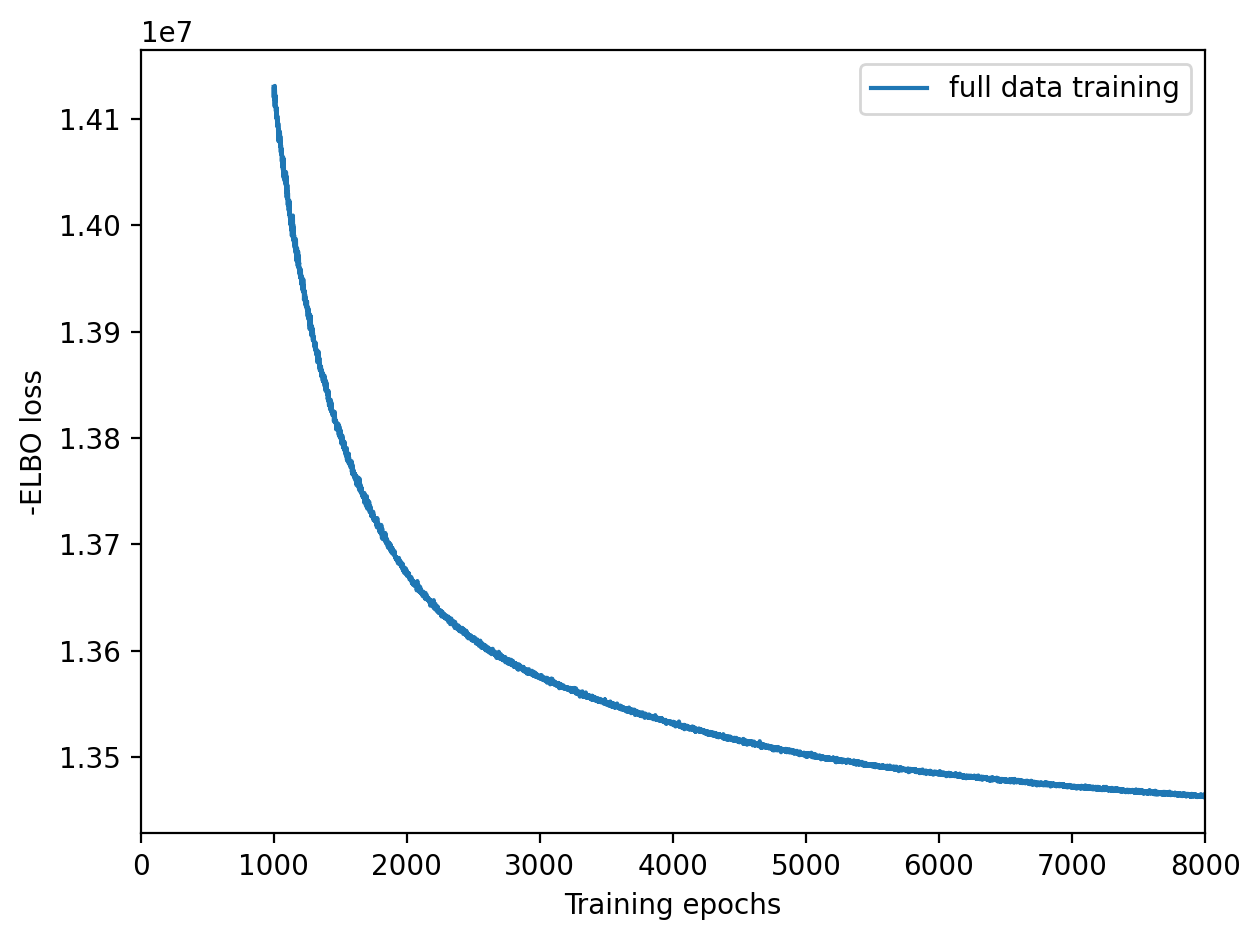

In [77]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [78]:
visium = mod.export_posterior(
    visium, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:09<00:00, 109.19it/s]


In [79]:
mod.save(f"{visium_results}/{sample}/cell2location_map", overwrite=True)

adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A4/cell2location_map/sp.h5ad'

+ Assessing mapping quality

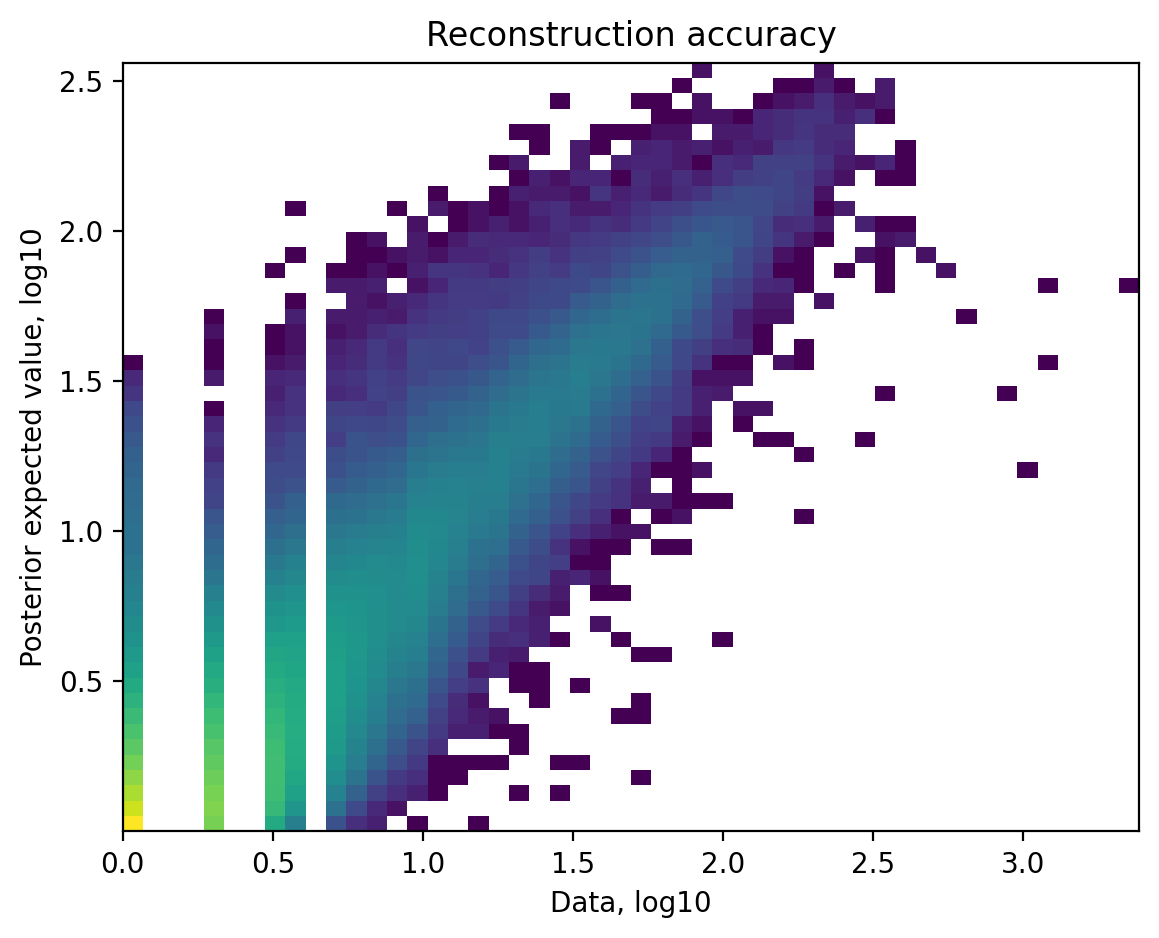

In [80]:
output_filename = f"{visium_results}/{sample}/{sample}_reconstruction_accuracy.png"
mod.plot_QC()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Visualising cell abundance in spatial coordinates

In [81]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']

/tmp/ipykernel_1801561/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_1801561/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']


In [82]:
visium.obs['sample'] = 'tissue42'

/tmp/ipykernel_1801561/2867631362.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs['sample'] = 'tissue42'


In [83]:
output_filename = f"{visium_results}/{sample}/{sample}_cell_types.png"

# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor': 'black', 'figure.figsize': [4.5, 5]}):
    ax = sc.pl.spatial(slide, cmap='magma',
                       # show first 13 cell types
                       color=['MMP9+ Inflammatory macrophage', 'MPO+ mono-neutrophil', 'LYVE1+ Macrophage', 'Macrophages', 'Monocytes', 'Paneth',
                              'Proximal progenitor', 'Distal progenitor', 'MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA',
                              'Stromal 1 (ADAMDEC1+)', 'Stromal 1 (CCL11+)', 'Stromal 2 (CH25H+)', 'Stromal 2 (NPY+)', 'Stromal 3 (C7+)',
                              'Stromal 3 (KCNN3+)'],
                       ncols=4, size=1.3,
                       img_key='hires',
                       # limit color scale at 99.2% quantile of cell abundance
                       vmin=0, vmax='p99.2',
                       show=False)  # Don't display the plot, just create it

    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

In [84]:
output_filename = f"{visium_results}/{sample}/{sample}_multiple_cell_types.png"
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth', 'Macrophages']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
        # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [85]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium, resolution=1.1)

# add region as categorical variable
visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(
/tmp/ipykernel_1801561/65762167.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")


In [86]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [87]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(8, 8))
    sc.pl.umap(visium, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [88]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(4.5, 5))
    sc.pl.spatial(visium, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden_on_tissue.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [89]:
from cell2location import run_colocation
res_dict, visium = run_colocation(
    visium,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/{sample}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_2265locations_95factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_2265locations_95factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_2265locations_95factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_2265locations_95factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_29combinations_2265locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


In [90]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
output_filename = f"{visium_results}/{sample}/{sample}_factors.png"
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [91]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [92]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A4/cell2location_map/sp.h5ad'

In [93]:
# list cell types and genes for plotting
output_filename = f"{visium_results}/{sample}/{sample}_selected_genes.png"
ctypes = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium, 'tissue42', batch_key='sample')
    plot_genes_per_cell_type(slide, genes, ctypes)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Working with the posterior distribution and computing arbitrary quantiles

In [94]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:06<00:00, 147.66it/s]


(1000, 2265, 95)

In [95]:
# Compute any quantile of the posterior distribution
output_filename = f"{visium_results}/{sample}/{sample}_posterior_distribution.png"
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

### Slide A8 (Fetal donor D, 12PCW, whole colon section slide)

In [14]:
adata_ref = sc.read_h5ad(f"{reference_results}/sc.h5ad")
mod = torch.load(f"{reference_results}/model.pt")

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Activated T,BEST4+ epithelial,Branch A1 (iMN),Branch A2 (IPAN/IN),Branch A3 (IPAN/IN)
gene_ids,,,,,
A1BG,0.236314,0.011777,0.164333,0.145132,0.163083
A1CF,0.023012,0.486183,0.001921,0.004112,0.009547
A2M,0.098528,0.020799,0.007336,0.015445,0.068924
A4GALT,0.024760,0.011315,0.003136,0.015210,0.027564
AAAS,0.060599,0.091847,0.138162,0.161428,0.296883


In [15]:
sample = 'A8'

visium = sc.read_h5ad(f'{visium_slides}/{sample}_raw.h5ad')

In [16]:
visium.var_names_make_unique()

In [17]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium.var_names, inf_aver.index)
visium = visium[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium, batch_key="Sample_ID")

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [18]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2600  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11811 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A8     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float

Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:07<00:00, 17.75it/s, v_num=1, elbo_train=1.41e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:07<00:00, 18.72it/s, v_num=1, elbo_train=1.41e+7]


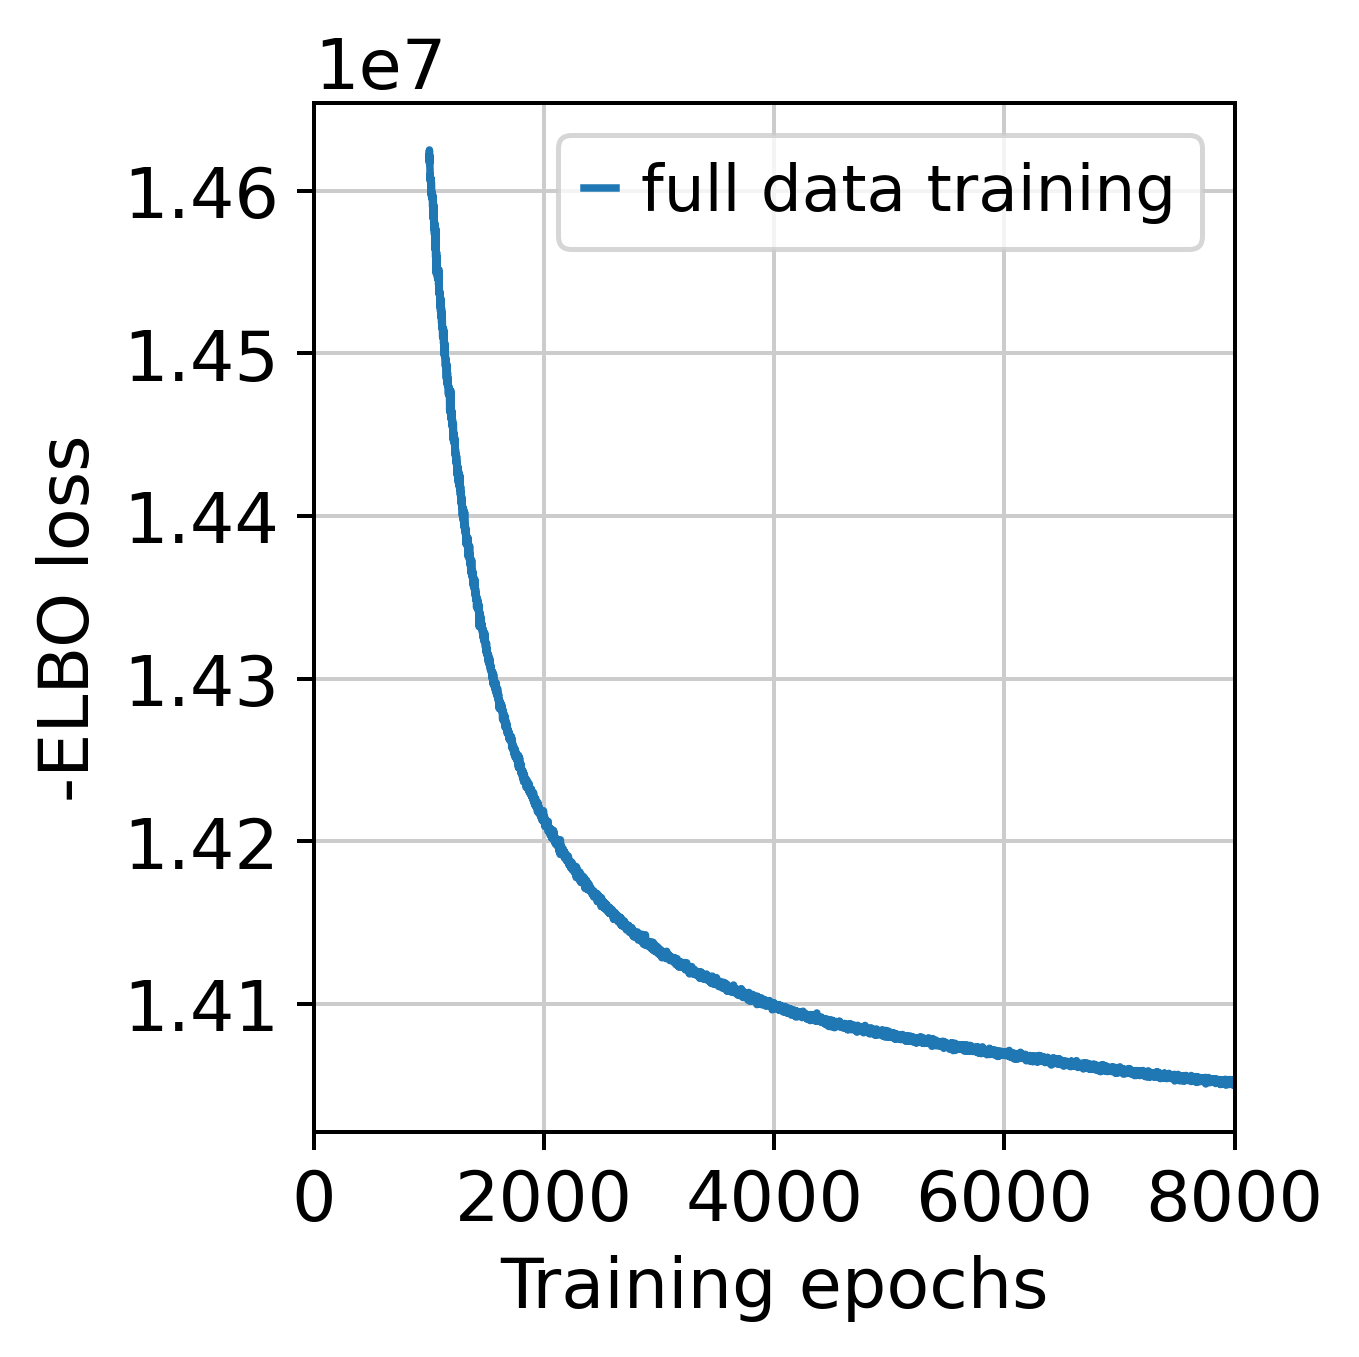

In [19]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [20]:
visium = mod.export_posterior(
    visium, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:09<00:00, 102.83it/s]


In [21]:
mod.save(f"{visium_results}/{sample}/cell2location_map", overwrite=True)

adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A8/cell2location_map/sp.h5ad'

+ Assessing mapping quality

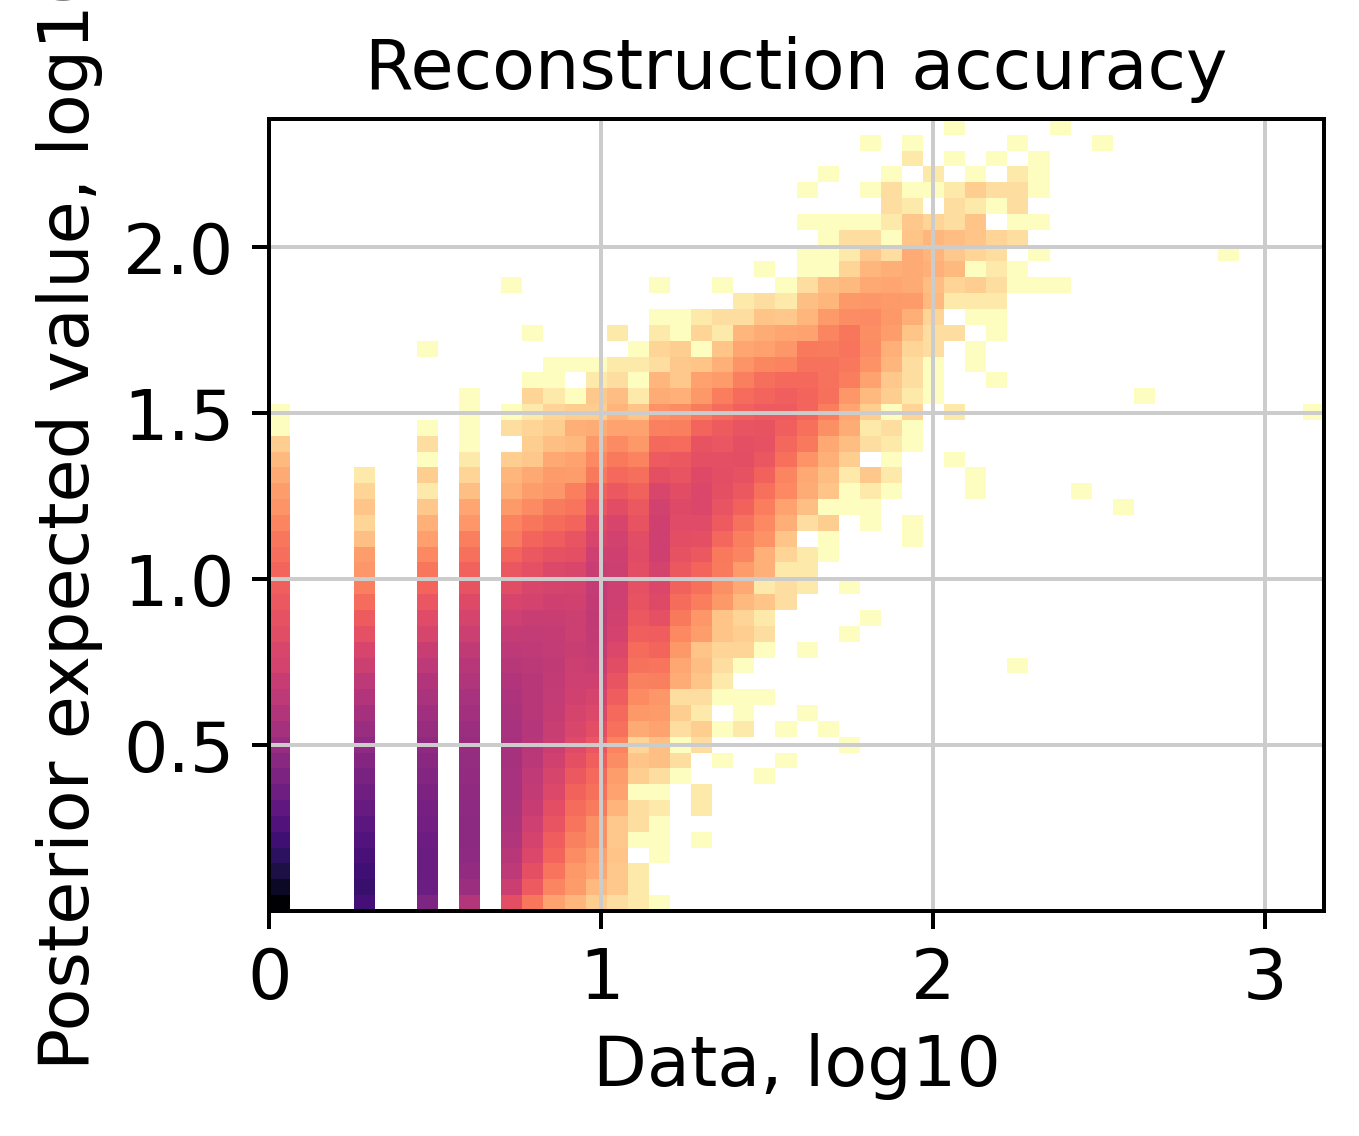

In [22]:
output_filename = f"{visium_results}/{sample}/{sample}_reconstruction_accuracy.png"
mod.plot_QC()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Visualising cell abundance in spatial coordinates

In [23]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']

/tmp/ipykernel_1805966/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_1805966/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']


In [24]:
visium.obs['sample'] = 'tissue42'

/tmp/ipykernel_1805966/2867631362.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs['sample'] = 'tissue42'


In [25]:
output_filename = f"{visium_results}/{sample}/{sample}_cell_types.png"

# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor': 'black', 'figure.figsize': [4.5, 5]}):
    ax = sc.pl.spatial(slide, cmap='magma',
                       # show first 13 cell types
                       color=['MMP9+ Inflammatory macrophage', 'MPO+ mono-neutrophil', 'LYVE1+ Macrophage', 'Macrophages', 'Monocytes', 'Paneth',
                              'Proximal progenitor', 'Distal progenitor', 'MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA',
                              'Stromal 1 (ADAMDEC1+)', 'Stromal 1 (CCL11+)', 'Stromal 2 (CH25H+)', 'Stromal 2 (NPY+)', 'Stromal 3 (C7+)',
                              'Stromal 3 (KCNN3+)'],
                       ncols=4, size=1.3,
                       img_key='hires',
                       # limit color scale at 99.2% quantile of cell abundance
                       vmin=0, vmax='p99.2',
                       show=False)  # Don't display the plot, just create it

    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

In [26]:
output_filename = f"{visium_results}/{sample}/{sample}_multiple_cell_types.png"
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth', 'Macrophages']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
        # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [27]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium, resolution=1.1)

# add region as categorical variable
visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(
/tmp/ipykernel_1805966/65762167.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")


In [28]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [29]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(8, 8))
    sc.pl.umap(visium, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [30]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(4.5, 5))
    sc.pl.spatial(visium, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden_on_tissue.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [31]:
from cell2location import run_colocation
res_dict, visium = run_colocation(
    visium,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/{sample}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_29combinations_2600locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


In [32]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
output_filename = f"{visium_results}/{sample}/{sample}_factors.png"
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [33]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [34]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A8/cell2location_map/sp.h5ad'

In [37]:
# list cell types and genes for plotting
output_filename = f"{visium_results}/{sample}/{sample}_selected_genes.png"
ctypes = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium, 'tissue42', batch_key='sample')
    plot_genes_per_cell_type(slide, genes, ctypes)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Working with the posterior distribution and computing arbitrary quantiles

In [38]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:06<00:00, 147.09it/s]


(1000, 2600, 95)

In [39]:
# Compute any quantile of the posterior distribution
output_filename = f"{visium_results}/{sample}/{sample}_posterior_distribution.png"
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

### Slide A9 (Fetal donor D, 12PCW, whole colon section slide)

In [106]:
sample = 'A9'

visium = sc.read_h5ad(f'{visium_slides}/{sample}_raw.h5ad')

In [107]:
visium.var_names_make_unique()

In [109]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium.var_names, inf_aver.index)
visium = visium[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium, batch_key="Sample_ID")

In [110]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2255  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11811 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A9     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:35<00:00, 17.39it/s, v_num=1, elbo_train=1.34e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:35<00:00, 17.56it/s, v_num=1, elbo_train=1.34e+7]


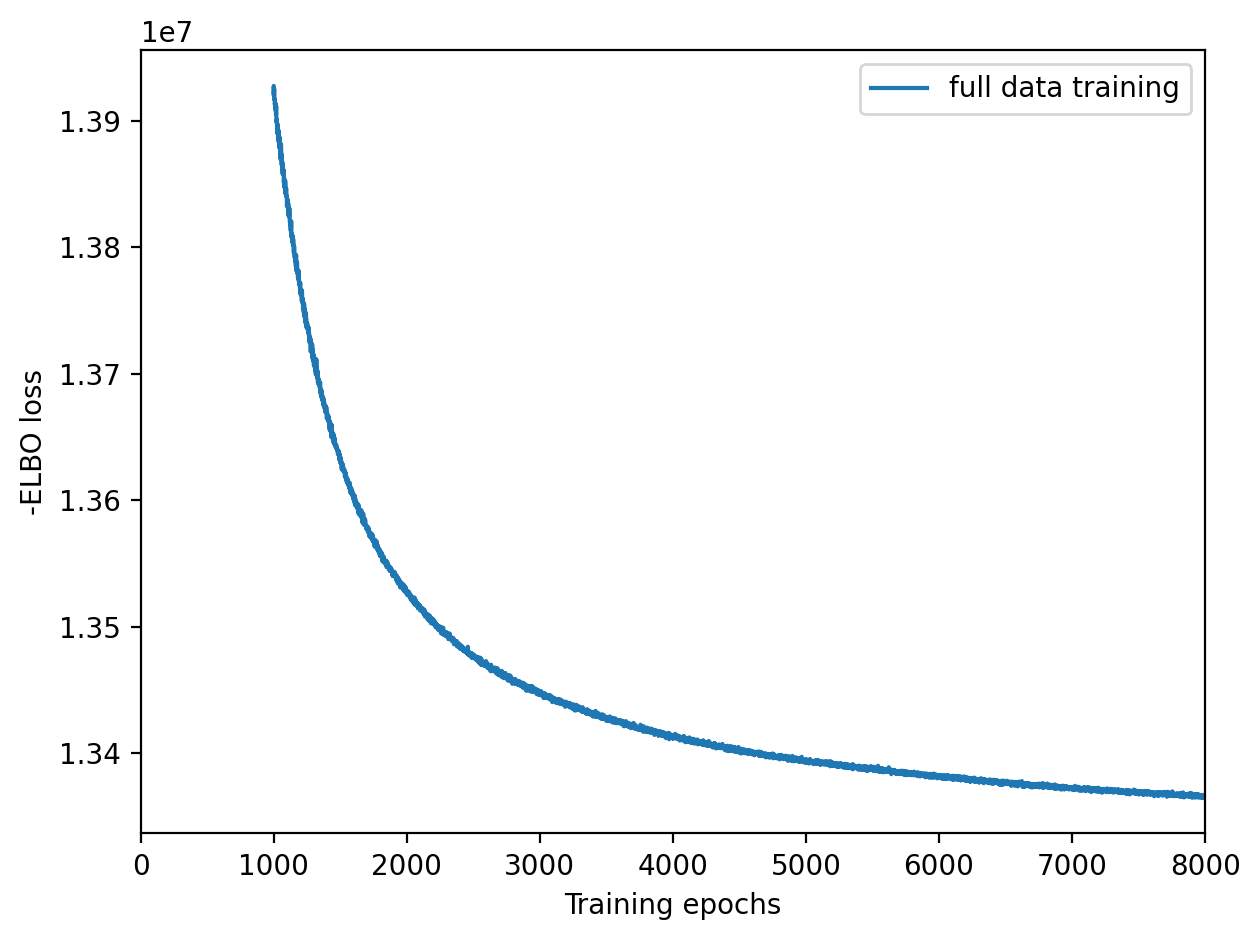

In [111]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [112]:
visium = mod.export_posterior(
    visium, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:09<00:00, 104.68it/s]


In [113]:
mod.save(f"{visium_results}/{sample}/cell2location_map", overwrite=True)

adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A9/cell2location_map/sp.h5ad'

+ Assessing mapping quality

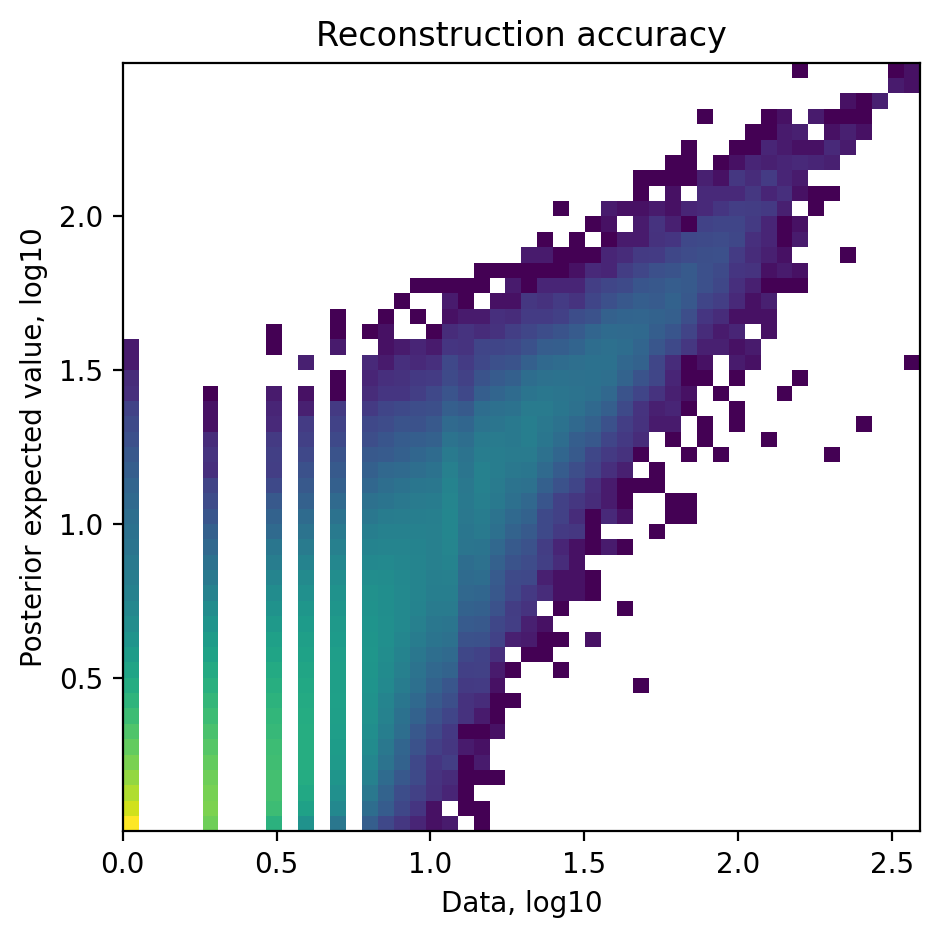

In [114]:
output_filename = f"{visium_results}/{sample}/{sample}_reconstruction_accuracy.png"
mod.plot_QC()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Visualising cell abundance in spatial coordinates

In [115]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']

/tmp/ipykernel_1805966/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']
/tmp/ipykernel_1805966/1370158470.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs[visium.uns['mod']['factor_names']] = visium.obsm['q05_cell_abundance_w_sf']


In [116]:
visium.obs['sample'] = 'tissue42'

/tmp/ipykernel_1805966/2867631362.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs['sample'] = 'tissue42'


In [117]:
output_filename = f"{visium_results}/{sample}/{sample}_cell_types.png"

# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor': 'black', 'figure.figsize': [4.5, 5]}):
    ax = sc.pl.spatial(slide, cmap='magma',
                       # show first 13 cell types
                       color=['MMP9+ Inflammatory macrophage', 'MPO+ mono-neutrophil', 'LYVE1+ Macrophage', 'Macrophages', 'Monocytes', 'Paneth',
                              'Proximal progenitor', 'Distal progenitor', 'MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA',
                              'Stromal 1 (ADAMDEC1+)', 'Stromal 1 (CCL11+)', 'Stromal 2 (CH25H+)', 'Stromal 2 (NPY+)', 'Stromal 3 (C7+)',
                              'Stromal 3 (KCNN3+)'],
                       ncols=4, size=1.3,
                       img_key='hires',
                       # limit color scale at 99.2% quantile of cell abundance
                       vmin=0, vmax='p99.2',
                       show=False)  # Don't display the plot, just create it

    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

In [118]:
output_filename = f"{visium_results}/{sample}/{sample}_multiple_cell_types.png"
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth', 'Macrophages']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
        # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [119]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium, resolution=1.1)

# add region as categorical variable
visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(
/tmp/ipykernel_1805966/65762167.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  visium.obs["region_cluster"] = visium.obs["leiden"].astype("category")


In [120]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [121]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(8, 8))
    sc.pl.umap(visium, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [122]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(4.5, 5))
    sc.pl.spatial(visium, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5, show=False)
    plt.savefig(f"{visium_results}/{sample}/{sample}_leiden_on_tissue.png", bbox_inches="tight")
    plt.close()

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [123]:
from cell2location import run_colocation
res_dict, visium = run_colocation(
    visium,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/{sample}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_29combinations_2255locations_95factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


In [124]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
output_filename = f"{visium_results}/{sample}/{sample}_factors.png"
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [125]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [126]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/{sample}/cell2location_map/sp.h5ad"
visium.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results//A9/cell2location_map/sp.h5ad'

In [127]:
# list cell types and genes for plotting
output_filename = f"{visium_results}/{sample}/{sample}_selected_genes.png"
ctypes = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'TA', 'Paneth']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium, 'tissue42', batch_key='sample')
    plot_genes_per_cell_type(slide, genes, ctypes)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

### Working with the posterior distribution and computing arbitrary quantiles

In [128]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:06<00:00, 152.87it/s]


(1000, 2255, 95)

In [129]:
# Compute any quantile of the posterior distribution
output_filename = f"{visium_results}/{sample}/{sample}_posterior_distribution.png"
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()